In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/Furniture_dataset_2.zip -d /content/Furniture_dataset_2

Archive:  /content/drive/MyDrive/Furniture_dataset_2.zip
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/annotations.json  
   creating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1282_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1283_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1284_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1285_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1286_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1287_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1288_0000.jpg  
  inflating: /content/Furniture_dataset_2/Furniture_dataset_2/bed/Image Sequence_1289_0000.jpg  
  inflating: /conte

In [6]:
import os
import random
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.io import read_image

Откроем файл с аннотациями для набора данных.

In [8]:
import json

file_annot = open('/content/Furniture_dataset_2/Furniture_dataset_2/annotations.json')
data_json = json.load(file_annot)
file_annot.close()


Покажем наглядно как выглядят изображения с метками класса

<ipython-input-9-59e18d61ac81>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(size, size, i+1)


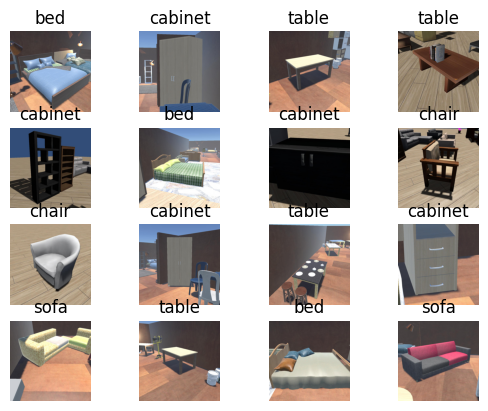

In [9]:
def show_images(data,  size=4):
    samples = random.choices(data["annotations"], k=size*size)

    fig, ax = plt.subplots()
    for i in range(size*size):
      img_path = [t["file_name"] for t in data["images"] if t["id"] == samples[i]["image_id"]][0]
      img_path = os.path.join("/content/Furniture_dataset_2/Furniture_dataset_2", img_path)
      img = np.asarray(Image.open(img_path))
      plt.subplot(size, size, i+1)
      plt.imshow(img)
      plt.title([t["name"] for t in data["categories"] if t["id"] == samples[i]["category_id"]][0])
      plt.axis('off')

show_images(data_json)

In [10]:
df_annotations = pd.DataFrame.from_dict(data_json["annotations"])
df_images = pd.DataFrame.from_dict(data_json["images"])
df_cat = pd.DataFrame.from_dict(data_json["categories"])

df_merged_an_img = df_annotations.merge(df_images, how="left", left_on="image_id", right_on="id")
df_full = df_merged_an_img.merge(df_cat, how="left", left_on="category_id", right_on="id")
df_full.drop(['id_x', 'id_y'], axis=1, inplace=True)
df_full

,image_id,category_id,file_name,weight,height,date_captured,id,name
0,1,1,bed/Image Sequence_1282_0000.jpg,800,800,2023-07-04,1,bed
1,2,1,bed/Image Sequence_1283_0000.jpg,800,800,2023-07-04,1,bed
2,3,1,bed/Image Sequence_1284_0000.jpg,800,800,2023-07-04,1,bed
3,4,1,bed/Image Sequence_1285_0000.jpg,800,800,2023-07-04,1,bed
4,5,1,bed/Image Sequence_1286_0000.jpg,800,800,2023-07-04,1,bed
...,...,...,...,...,...,...,...,...
1007,1008,4,table/Image Sequence_1803_0000.jpg,800,800,2023-07-04,4,table
1008,1009,4,table/Image Sequence_1804_0000.jpg,800,800,2023-07-04,4,table
1009,1010,4,table/Image Sequence_1805_0000.jpg,800,800,2023-07-04,4,table
1010,1011,4,table/Image Sequence_1806_0000.jpg,800,800,2023-07-04,4,table


Разделим набор данных на три подвыборки

In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_full, test_size=0.2, stratify=df_full["name"])
test_df, val_df = train_test_split(test_df, test_size=0.5)
print(len(train_df), len(val_df), len(test_df))

809 102 101


In [12]:
train_df.groupby('name')["name"].count()

name
bed        151
cabinet    172
chair      156
sofa       145
table      185
Name: name, dtype: int64

Создадим собственный класс для загрузки изображений из датасета

In [13]:

class CustomImageDataset(Dataset):
    def __init__(self, df_annotations: pd.DataFrame, img_dir: str, transform=None):
        self.data = df_annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]["file_name"])
        image = Image.open(img_path)
        #image = transforms.functional.adjust_contrast(image, 6)

        label = self.data.iloc[idx, 1] - 1
        if self.transform:
            image = self.transform(image)
        return image, label




С помощью transforms сделаем разные преобразования (тренировочный и проверочный набор данных) для изображений

In [19]:
test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        #transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

generator = torch.Generator().manual_seed(42)

train_dataset = CustomImageDataset(train_df, "/content/Furniture_dataset_2/Furniture_dataset_2", transform=train_transform)
val_dataset = CustomImageDataset(val_df, "/content/Furniture_dataset_2/Furniture_dataset_2", transform=test_transform)
test_dataset = CustomImageDataset(test_df, "/content/Furniture_dataset_2/Furniture_dataset_2", transform=test_transform)

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Выведем тестовое изображение и метку класса

Размер батча: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


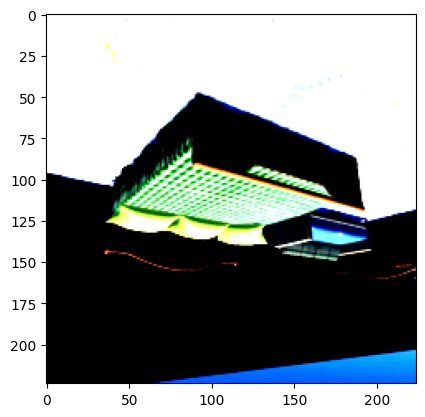

Label: 0


In [21]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Размер батча: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

В качестве модели была выбрана ResNet34 с претренировочными весами. Далее были заморожены все слои и изменен слой классификатора

In [30]:
from torchvision import models
from torch import nn

model = models.resnet50(pretrained=True).to(torch.device('cuda:0'))
model.eval()

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5).to(torch.device('cuda:0'))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Проверим архитектуру модели и количество параметров доступных для тренировки

In [31]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
lr_m = 1e-5
epochs = 20
batch_size = 64

Выберем критерий для мультиклассовой классификации и оптимизатор (градиентный спуск)

In [33]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [34]:
def train_epoch(model, train_dataloader):
  model.train()

  stored_y = []
  stored_y_pred = []
  stored_loss = []

  for i, data in enumerate(train_dataloader, 0):

    X = data[0].to(device="cuda")
    y = data[1].to(device="cuda")

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):

      y_pred = model(X)
      loss = criterion(y_pred, y)

      y =  y.detach().cpu().numpy().tolist()
      y_pred =  y_pred.detach().cpu().numpy().tolist()


      stored_y.extend(y)
      stored_y_pred.extend(y_pred)
      stored_loss.append(loss.item())

      loss.backward()
      optimizer.step()

    #scheduler.step()

  loss = np.mean(stored_loss)
  final_y_pred = np.argmax(stored_y_pred, axis=1)
  metric = accuracy_score(stored_y, final_y_pred)

  return metric, loss

In [35]:
def val_epoch(model, val_dataloader):

  model.eval()

  stored_y = []
  stored_y_pred = []
  stored_loss = []

  for i, data in enumerate(val_dataloader, 0):
    X = data[0].to(device="cuda")
    y = data[1].to(device="cuda")

    optimizer.zero_grad()

    with torch.no_grad():
      y_pred = model(X)
      loss = criterion(y_pred, y)

      y =  y.detach().cpu().numpy().tolist()
      y_pred =  y_pred.detach().cpu().numpy().tolist()


      stored_y.extend(y)
      stored_y_pred.extend(y_pred)
      stored_loss.append(loss.item())


    #scheduler.step()

  loss = np.mean(stored_loss)
  final_y_pred = np.argmax(stored_y_pred, axis=1)
  metric = accuracy_score(stored_y, final_y_pred)

  return metric, loss

Обучение модели

In [36]:
train_acc_list, train_loss_list = [], []
val_acc_list, val_loss_list = [], []

for epoch in range(epochs):

    train_acc, train_loss = train_epoch(model, train_dataloader)
    print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')

    val_acc, val_loss = val_epoch(model, val_dataloader)

    print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)


Train Loss: 1.5993 Train Acc: 0.2262
Val Loss: 1.4414 Val Acc: 0.4706
Train Loss: 1.3856 Train Acc: 0.5674
Val Loss: 1.2020 Val Acc: 0.7451
Train Loss: 1.1632 Train Acc: 0.7355
Val Loss: 1.0139 Val Acc: 0.8235
Train Loss: 1.0149 Train Acc: 0.8022
Val Loss: 0.8654 Val Acc: 0.8431
Train Loss: 0.8952 Train Acc: 0.8269
Val Loss: 0.7961 Val Acc: 0.8627
Train Loss: 0.8173 Train Acc: 0.8245
Val Loss: 0.7130 Val Acc: 0.8529
Train Loss: 0.7535 Train Acc: 0.8455
Val Loss: 0.6693 Val Acc: 0.8627
Train Loss: 0.6881 Train Acc: 0.8603
Val Loss: 0.6323 Val Acc: 0.8529
Train Loss: 0.6488 Train Acc: 0.8603
Val Loss: 0.5837 Val Acc: 0.8824
Train Loss: 0.6100 Train Acc: 0.8739
Val Loss: 0.5436 Val Acc: 0.8824
Train Loss: 0.5768 Train Acc: 0.8727
Val Loss: 0.5556 Val Acc: 0.8627
Train Loss: 0.5549 Train Acc: 0.8752
Val Loss: 0.5365 Val Acc: 0.8922
Train Loss: 0.5295 Train Acc: 0.8888
Val Loss: 0.5243 Val Acc: 0.8824
Train Loss: 0.5140 Train Acc: 0.8900
Val Loss: 0.4873 Val Acc: 0.8824
Train Loss: 0.4975 T

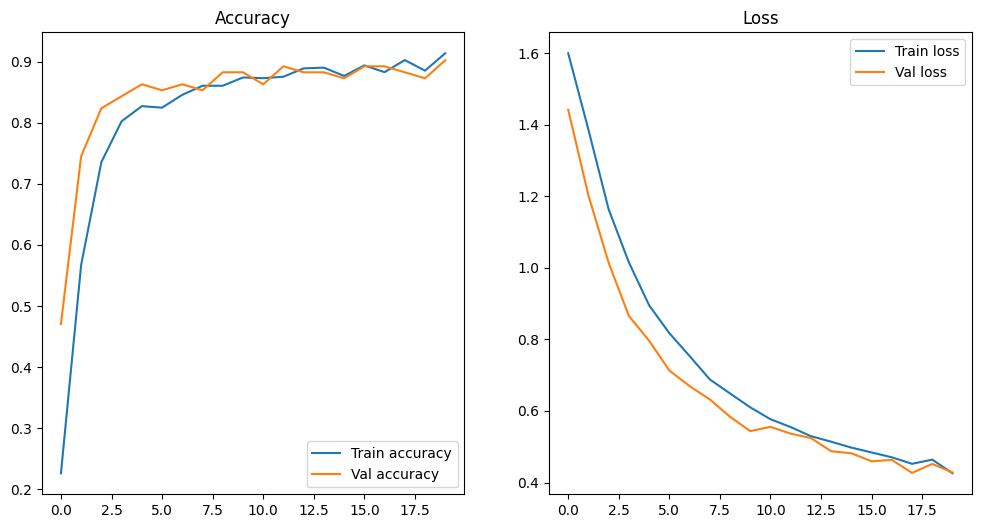

In [37]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_acc_list, label='Train accuracy' )
plt.plot(range(epochs), val_acc_list , label='Val accuracy' )
plt.title("Accuracy")
ax.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_list , label='Train loss' )
plt.plot(range(epochs), val_loss_list , label='Val loss')
plt.title("Loss")
ax.legend()

In [38]:
stored_y_pred = []
stored_y = []

for i, data in enumerate(test_dataloader, 0):
  X = data[0].to(device="cuda")
  y = data[1]

  y_pred = model(X)
  stored_y_pred.extend(torch.argmax(y_pred.cpu().detach(), axis=1).numpy().tolist())
  stored_y.extend(y.numpy().tolist())


Точность модели

In [39]:
accuracy_score(stored_y_pred, stored_y)

0.9504950495049505

In [40]:
from sklearn.metrics import precision_score, recall_score
precision_score(stored_y_pred, stored_y, average='macro'),  recall_score(stored_y_pred, stored_y, average='macro')

(0.9520823798627003, 0.9503759398496239)

In [41]:
def predict_single(model, img):
  return df_cat.iloc[torch.argmax(model(img.to(device="cuda")), axis=1).cpu().item()]["name"]

Тестирование случайных изображений из тестовой подвыборки

<ipython-input-42-8c53e7945494>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(size, size, i+1)


torch.Size([64, 3, 224, 224]) 43


torch.Size([64, 3, 224, 224]) 7


torch.Size([64, 3, 224, 224]) 40


torch.Size([64, 3, 224, 224]) 53


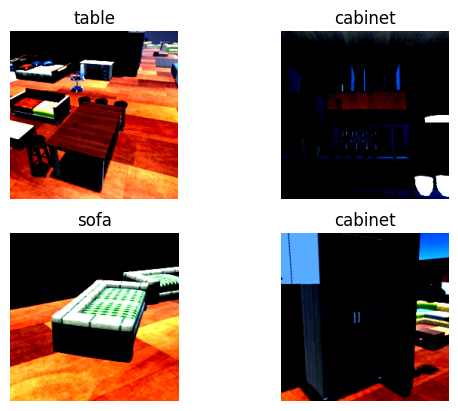

In [42]:
def show_images(data_loader,  size=4):
    fig, ax = plt.subplots()
    for i in range(size*size):
      img_batch = next(iter(data_loader))
      print(img_batch[0].shape, int(np.random.rand() * 64) )
      img_single = img_batch[0][int(np.random.rand() * 64)]
      plt.subplot(size, size, i+1)
      plt.imshow(img_single.permute(1, 2, 0))
      plt.title(predict_single(model, img_single.unsqueeze(0)))
      plt.axis('off')

show_images(test_dataloader, 2)

In [55]:
img = Image.open("/content/загрузка (5).jpg")
transformed = test_transform(img).unsqueeze(0).to(device="cuda")
transformed.shape

torch.Size([1, 3, 224, 224])

In [56]:
model(transformed)

tensor([[ 0.8378, -0.7252, -0.8898, -1.0953,  2.3584]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [57]:
df_cat.iloc[torch.argmax(model(transformed),axis=1).item()]["name"]

'cabinet'

(-0.5, 700.5, 499.5, -0.5)

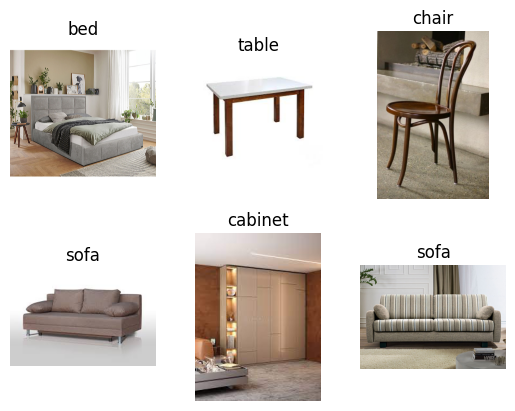

In [64]:
plt.subplot(2, 3, 1)
img_1 = Image.open("/content/1msd9gg3pqqscfg65qjvb9kodi61pb2o.jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')

plt.subplot(2, 3, 2)
img_1 = Image.open("/content/images.jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')

plt.subplot(2, 3, 3)
img_1 = Image.open("/content/photo_2023.jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')

plt.subplot(2, 3, 4)
img_1 = Image.open("/content/загрузка (4).jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')

plt.subplot(2, 3, 5)
img_1 = Image.open("/content/загрузка (5).jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')

plt.subplot(2, 3, 6)
img_1 = Image.open("/content/br1.jpg")
plt.imshow(img_1)
img_1 = test_transform(img_1)
plt.title(predict_single(model, img_1.unsqueeze(0)))
plt.axis('off')